# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filenames1 = ['ccbar0','phi0']
filenames1 = ['phi_new00','ccbar_new00']#,'ccbar_new00'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [3]:
if True:
    data = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        data = pd.concat([data,idata], sort=False)

    data = data.sample(frac = 1)
    float_columns=('Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore',\
                   'reconpt','reconphi0','reconthe0','px','py','pz','vx','vy','vz',\
                   'sdphi0','sdthe0','SecondHitPhiR0','SecondHitPhiL0','SecondHitTheR0','SecondHitTheL0',\
                   'sdphi1','sdthe1','SecondHitPhiR1','SecondHitPhiL1','SecondHitTheR1','SecondHitTheL1',\
                   'sdphi2','sdthe2','SecondHitPhiR2','SecondHitPhiL2','SecondHitTheR2','SecondHitTheL2',\
                   'sdphi3','sdthe3','SecondHitPhiR3','SecondHitPhiL3','SecondHitTheR3','SecondHitTheL3')
    int_columns=('NBDThit','Centrality', 'Charge', 'Arm','IsTrue0','IsTrue1','IsTrue2','IsTrue3')
    
    for float_column in float_columns:
        data[float_column] = data[float_column].astype('float32')
    for int_column in int_columns:
        data[int_column] = data[int_column].astype('int32')
    data.head()
    
    data = data[(data['Pt'] < 25) & (data['Ecore'] > 0.1) & (data['Ecore'] < 25) & (data['reconthe0'] < 25) & (data['reconthe0'] > -25) ]
    
    data.loc[idata['sdphi2'] == -10, 'IsTrue2'] = 1
    data.loc[idata['sdphi3'] == -10, 'IsTrue3'] = 1
    data['IsTrue0'] = data['IsTrue0']*data['IsTrue1'] * data['IsTrue2']*data['IsTrue3']
    data.loc[idata['IsTrue0'] > 0, 'IsTrue0'] = 1
    data.head()

In [7]:
data.head()

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,sdphi3,sdthe3,IsTrue3,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
3627368,1,1.070173,3.723445,1.438477,3.531250,28.985491,0.097717,1.012442,89,-1,...,-99.000000,-99.000000,-99.000000,0.520618,-0.495105,0,-99.000000,-99.000000,-99.000000,-99.000000
3797791,3,0.594967,-0.073632,1.209961,-0.436279,81.966347,0.191772,0.880861,27,-1,...,0.939882,13.530376,12.925542,-0.025935,0.732253,1,3.894561,4.838690,-15.463077,14.702785
2216595,3,1.438756,0.705263,1.843750,0.857422,-61.182930,-0.079834,1.647819,3,1,...,0.647577,-4.115347,-2.774180,-10.000000,-10.000000,1,-99.000000,0.773836,-99.000000,-0.538668
2808658,3,0.734178,3.127656,1.893555,2.830078,-73.075699,0.156006,0.677198,81,-1,...,-99.000000,-99.000000,-99.000000,-1.211649,0.432048,1,-99.000000,-99.000000,-99.000000,-99.000000
882884,3,1.266579,-0.198458,1.602539,-0.358398,-7.018403,0.080322,1.150902,78,-1,...,-99.000000,96.071609,-99.000000,-10.000000,-10.000000,1,-99.000000,-99.000000,-99.000000,-99.000000


In [8]:
print(data.size, data.shape)

521870592 (10872304, 48)


In [4]:
# удалим лишние колонки
data = data.drop(columns = ['IsTrue1','IsTrue2','IsTrue3','px','py','pz','vx','vy','vz','sdphi0','sdphi1','sdphi2','sdphi3','sdthe0','sdthe1','sdthe2','sdthe3','reconphi0','reconthe0'])

In [19]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(4, 3, figsize=(15, 6))
    for i, feature in enumerate(['IsTrue0', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


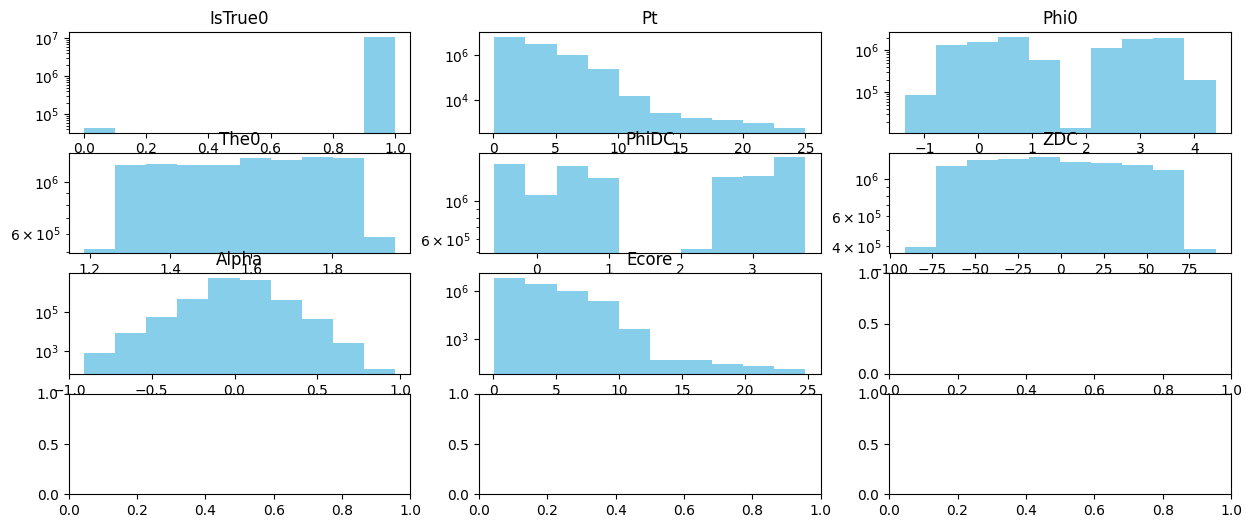

In [11]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [5]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['IsTrue0']
    data = data.drop(columns = ['IsTrue0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [6]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

3624101 7248203


In [7]:
X_test

,NBDThit,Pt,Phi0,The0,PhiDC,ZDC,Alpha,Ecore,Centrality,Charge,...,SecondHitTheR1,SecondHitTheL1,SecondHitPhiR2,SecondHitPhiL2,SecondHitTheR2,SecondHitTheL2,SecondHitPhiR3,SecondHitPhiL3,SecondHitTheR3,SecondHitTheL3
2529746,1,2.306706,-0.070686,1.851562,0.019424,-63.628010,-0.047485,2.191386,79,1,...,-16.998676,-16.157635,245.965439,242.711441,-17.988972,-16.873350,-99.000000,243.446579,-99.000000,-16.786604
1540592,3,3.202845,0.324272,1.453125,0.387695,26.176136,-0.032440,2.904097,39,1,...,-45.331200,-43.767941,-37.991108,187.373962,-2.537638,-45.054050,-99.000000,189.922562,-99.000000,-44.382416
1129165,2,2.671313,2.553910,1.469727,2.628906,22.455349,-0.038605,2.791881,89,1,...,152.839142,-99.000000,-283.732819,-99.000000,152.477997,-99.000000,47.199390,41.335884,-10.470406,-10.892714
3172799,1,3.622376,3.752032,1.422852,3.695312,32.893101,0.029938,3.866220,5,-1,...,-99.000000,-99.000000,9.392568,7.331793,-8.816803,-9.988121,-99.000000,-99.000000,-99.000000,-99.000000
3440332,3,0.541740,0.768577,1.442383,0.385742,27.603199,0.191284,0.566231,89,-1,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,214.736099,-99.000000,-24.921986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066323,3,1.649968,0.692947,1.294922,0.821777,62.205719,-0.068481,1.763508,33,1,...,14.779050,14.852240,-99.000000,20.534582,-99.000000,9.002835,9.422154,2.736239,-11.640825,-11.826103
3259234,2,0.720994,-0.111185,1.326172,-0.399414,54.576279,0.149048,0.560892,38,-1,...,7.862130,-99.000000,-99.000000,1.440562,-99.000000,10.558944,-0.000000,-99.000000,-1.765811,-99.000000
2405717,3,5.240592,0.408319,1.352539,0.367920,49.153648,0.019989,5.567002,7,-1,...,-7.620763,-7.375928,3.733569,2.204752,11.976396,-10.730393,1.111501,37.728233,14.535968,-13.244988
4701075,1,5.019787,3.703383,1.304688,3.660156,60.502312,0.023315,5.027625,67,-1,...,45.385128,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000


In [8]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [41]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.01      1.00      0.01     14528
           1       1.00      0.45      0.62   3609573

    accuracy                           0.45   3624101
   macro avg       0.50      0.72      0.32   3624101
weighted avg       1.00      0.45      0.61   3624101

confusion matrix
[[  14526       2]
 [2001665 1607908]]


In [42]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.2],
    "min_samples_split": [0.01],
    "max_depth":[12],
    "max_features":["sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

KeyboardInterrupt: 

# Cross Validation

In [44]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14528
           1       1.00      1.00      1.00   3609573

    accuracy                           1.00   3624101
   macro avg       0.89      1.00      0.94   3624101
weighted avg       1.00      1.00      1.00   3624101



In [45]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.014662913994312804
roc auc: 0.9997374803125548
f1 score: 0.999689481228579


Text(0.5, 1.0, 'ROC AUC Curve')

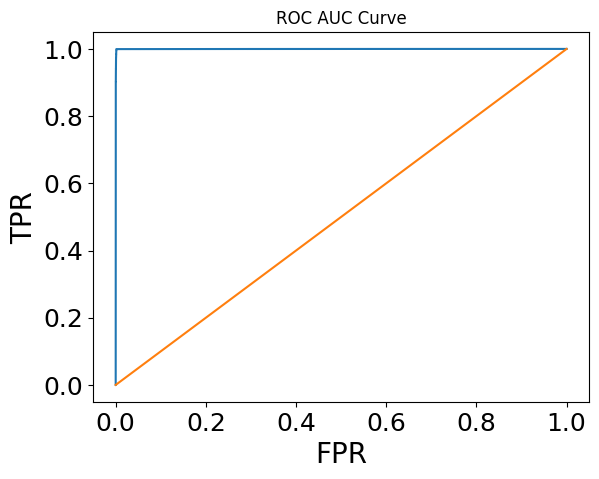

In [46]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [47]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.026125926261011737


In [94]:
i = 871000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.999 0.0017
0.44985288227257497 0.0017208149779735682 0.9991090358887326


In [49]:
print(sum(predicted),len(predicted))

3605683 3624101


In [50]:
kek_data = data
kek_data = kek_data.drop(columns = ['IsTrue0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.98310037098612


In [51]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_Hits_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 50, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 50, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 50, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 50, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 50, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 50, 0, 5, 10, 0, 100)

In [52]:
mycute,mycuth, AIcute, AIcuth = 0.1, 0.1, 0.1, 0.1
norm_e, norm_h = 0.1, 0.1
data0 = data.reset_index()  # make sure indexes pair with number of rows

sigma = 3

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>1000000: break
    sdphi0, sdphi1, sdphi2, sdphi3 = 0, 0, 0, 0
    sdthe0, sdthe1, sdthe2, sdthe3 = 0, 0, 0, 0
    centrality, pt, IsTrue0 = row['Centrality'], row['Pt'], row['IsTrue0']

    if pt<0.4 or centrality<0: continue
    if IsTrue0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ( abs(sdphi0) < sigma and abs(sdthe0) < sigma and abs(sdphi1) < sigma and abs(sdthe1) < sigma ) and ( ( abs(sdphi2) < sigma and abs(sdthe2) < sigma ) or ( abs(sdphi3) < sigma and abs(sdthe3) < sigma ) ):
        if IsTrue0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if IsTrue0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if IsTrue0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [53]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

959903.1 8015705.1 1.0 1.0 0.986 0.001 0.001 0.001


In [54]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

790.12 0.986 0.001 23704


In [55]:
%run input/Format.ipynb

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


45.0 3513.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


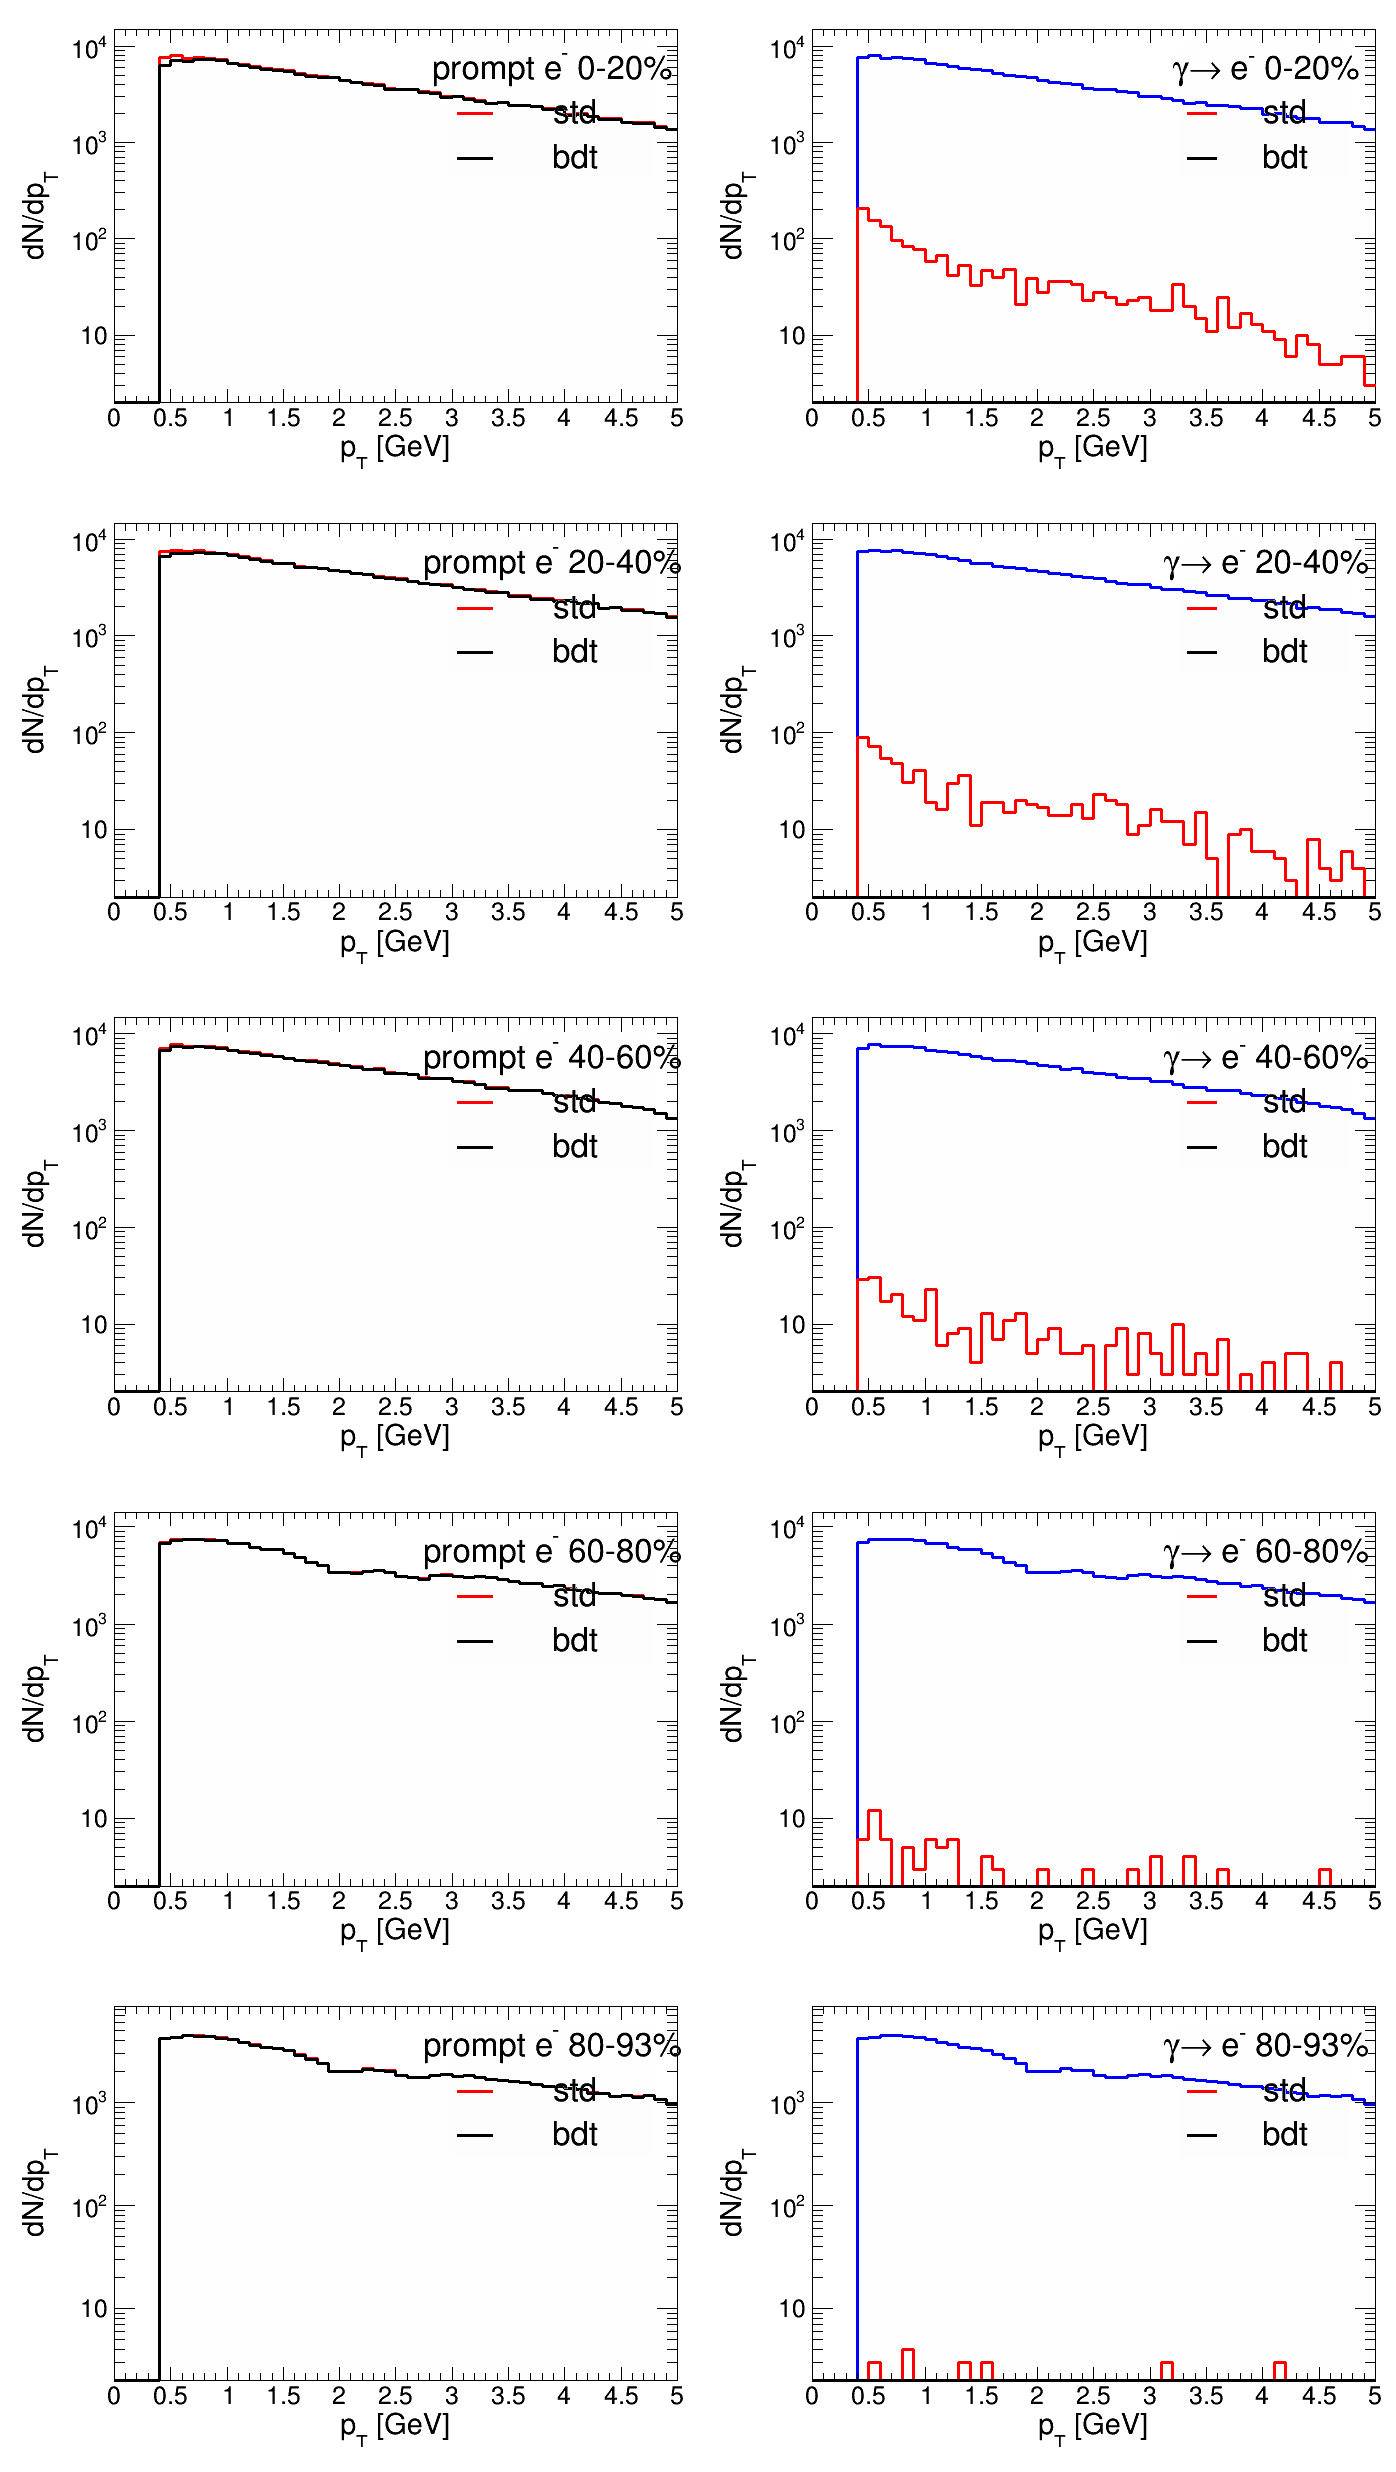

In [56]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    proj.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

In [57]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [58]:
import pickle
with open('output/bdt_hit.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[1 1 1 1 1 1 1 1 1 1]


In [59]:
import pickle
# load
with open('output/bdt_hit.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[1 1 1 1 1 1 1 1 1 1]


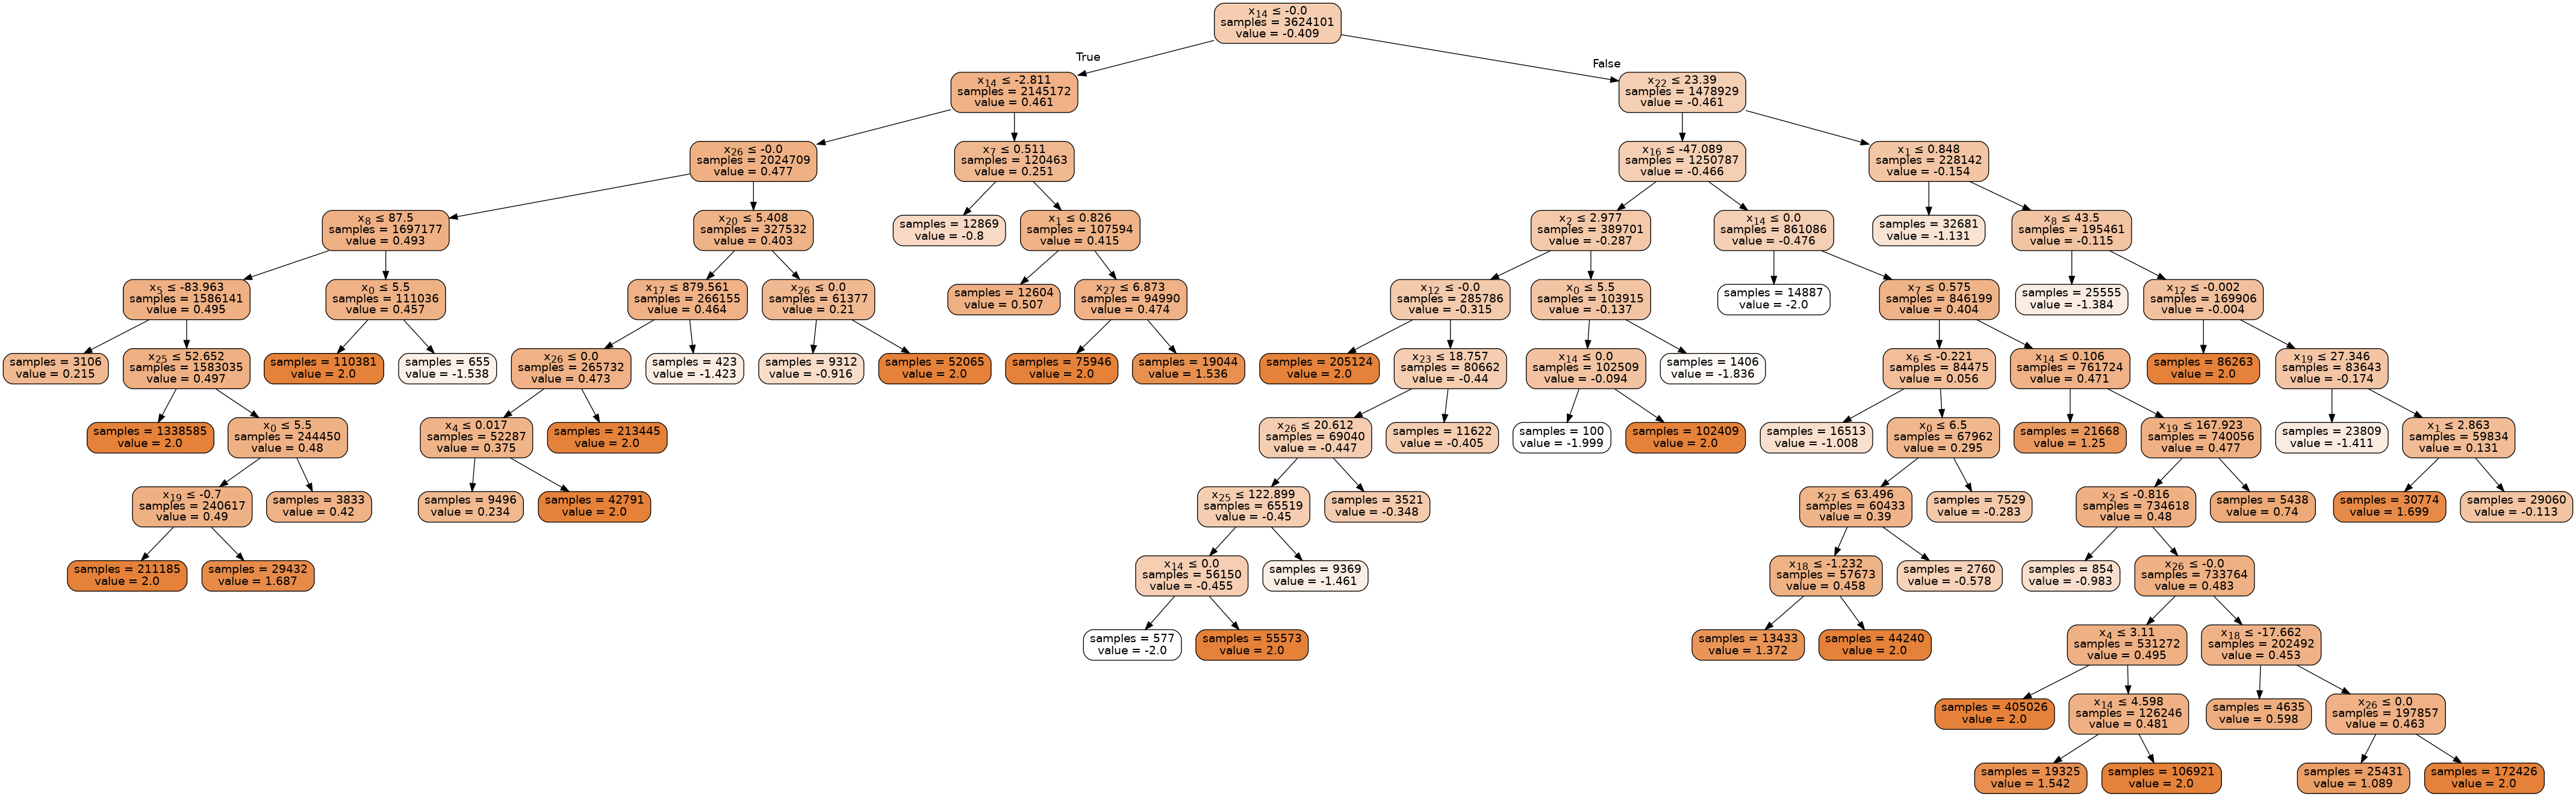

In [60]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [61]:
clf2.predict(kek_data[0:100])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [62]:
clf2.predict_proba(kek_data[0:100])

array([[0.01689963, 0.98310037],
       [0.03680696, 0.96319304],
       [0.00942395, 0.99057605],
       [0.02013921, 0.97986079],
       [0.01450881, 0.98549119],
       [0.02257884, 0.97742116],
       [0.01722893, 0.98277107],
       [0.01167017, 0.98832983],
       [0.01796262, 0.98203738],
       [0.04438849, 0.95561151],
       [0.02040617, 0.97959383],
       [0.01239011, 0.98760989],
       [0.0105451 , 0.9894549 ],
       [0.00888842, 0.99111158],
       [0.00811943, 0.99188057],
       [0.01237868, 0.98762132],
       [0.02886716, 0.97113284],
       [0.02169722, 0.97830278],
       [0.0257451 , 0.9742549 ],
       [0.00969706, 0.99030294],
       [0.01002296, 0.98997704],
       [0.0145824 , 0.9854176 ],
       [0.00914141, 0.99085859],
       [0.02893697, 0.97106303],
       [0.01208052, 0.98791948],
       [0.00683224, 0.99316776],
       [0.15486718, 0.84513282],
       [0.01693745, 0.98306255],
       [0.14108112, 0.85891888],
       [0.01602092, 0.98397908],
       [0.

In [63]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}


In [64]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.04438849, 0.95561151],
       [0.02040617, 0.97959383],
       [0.01239011, 0.98760989],
       [0.0105451 , 0.9894549 ],
       [0.00888842, 0.99111158],
       [0.00811943, 0.99188057],
       [0.01237868, 0.98762132],
       [0.02886716, 0.97113284],
       [0.02169722, 0.97830278],
       [0.0257451 , 0.9742549 ],
       [0.00969706, 0.99030294]])

In [65]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[1.64557122 2.03813889 2.46563182 2.46156755 2.6319669  2.72866452
 2.28060232 1.64004202 2.22479884 1.86427261]
[-0.82095269  0.00876745 -0.41346833  0.77131678  0.68339724 -0.66510907
 -1.03994571 -1.13538926 -1.63816184 -0.61649379 -1.40417546]
[0.83829159 0.88474362 0.92169709 0.92140326 0.93289079 0.93869703
 0.90725774 0.83754065 0.90245446 0.86579418]


In [66]:
best_gbc = clf2.best_estimator_

In [67]:
n_estim = best_gbc.n_estimators

In [68]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[3.06937125 3.87130075 4.3783888  4.54149245 4.71407754 4.80534292
 4.37932337 3.5157587  3.8086352  3.63342847]
[0.95561151 0.97959383 0.98760989 0.9894549  0.99111158 0.99188057
 0.98762132 0.97113284 0.97830278 0.9742549 ]
0.2


In [69]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [70]:
print(log_odds_predictions)

[[2.0, 2.0, -0.11260558804418454, 2.0, 2.0, 2.0, 2.0, 2.0, 1.5416265750286369, 1.6867092571714895], [-1.301114548507092, -0.8333795217735218, 2.094509697587746, 1.6707986480351, 1.6705926749980358, 1.6744401281978305, -1.3086350963815148, -1.46834916248643, 1.6797024152657, -1.2161531674964818], [1.7732766815362744, 1.5880371198297916, 1.537924038316059, 0.2000912708999542, 1.5109121395137532, 1.484519476006036, 1.6725500354691123, 1.9225271237931083, 1.677630303444419, 1.8693835456422998], [1.6078222223189027, 1.6078222223189027, 1.5081038942171745, 1.3960105252355457, 1.3624366386135607, 1.3642850278723724, 1.531631273455276, 1.0017542785359126, 1.0831019598228955, 1.6681530028943399], [1.4136148442237322, 1.4374199525454443, 1.3756196802226845, 1.2780431779647092, 0.7937887557131046, 1.2721924180635917, 1.4088172287815433, 1.4760920575299692, 1.2721924180635917, 1.49452295991471], [1.3540092729374604, 1.308320537163684, 1.2864409365306955, 1.2111718136477263, 1.2325341589444792, 1.2

In [71]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 1.645571223000409
[3.06937125 3.87130075 4.3783888  4.54149245 4.71407754 4.80534292
 4.37932337 3.5157587  3.8086352  3.63342847]


In [72]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[2.0, -1.301114548507092, 1.7732766815362744, 1.6078222223189027, 1.4136148442237322, 1.3540092729374604, -1.010275839491514, 1.2609627234249874, -0.008842848435122331, 1.138403606994415, 1.1124229739270914, 1.0225857354674046, -0.9562715071344721, 0.9965666743062632, 1.0721274609648623, 0.8938864239494972, 1.0443581243854467, -0.09856603259603365, 1.0485700997406575, 0.9833201648261801], [2.0, -0.8333795217735218, 1.5880371198297916, 1.6078222223189027, 1.4374199525454443, 1.308320537163684, 1.2991179729260856, -0.5347111560956352, 1.183093830160957, 1.134973480850295, 1.127201033475625, 1.0225857354674046, 1.1279618218971696, 0.9965666743062632, 1.0526345229839476, 0.8938864239494972, 1.0366768080683149, -0.09856603259603365, 1.0235421564081482, 0.9833201648261801], [-0.11260558804418454, 2.094509697587746, 1.537924038316059, 1.5081038942171745, 1.3756196802226845, 1.2864409365306955, 1.2171097610243893, 1.1834262791882721, 1.1192577032456676, 1.118372674924125, 0.1906532494808

In [73]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [74]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [75]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

['NBDThit', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore', 'Centrality', 'Charge', 'Arm', 'reconpt', 'SecondHitPhiR0', 'SecondHitPhiL0', 'SecondHitTheR0', 'SecondHitTheL0', 'SecondHitPhiR1', 'SecondHitPhiL1', 'SecondHitTheR1', 'SecondHitTheL1', 'SecondHitPhiR2', 'SecondHitPhiL2', 'SecondHitTheR2', 'SecondHitTheL2', 'SecondHitPhiR3', 'SecondHitPhiL3', 'SecondHitTheR3', 'SecondHitTheL3']
28


In [76]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[14] <= -1.5686204335452203e-07) if (x[14] <= -2.8112694025039673) if (x[26] <= -2.769919689171729e-07) if (x[8] <= 87.5) if (x[5] > -83.96310806274414) if (x[25] <= 52.652183532714844)   return 2.0;  // | based on 1,338,585 samples
        if  (x[14] > -1.5686204335452203e-07) if (x[22] <= 23.390352249145508) if (x[16] > -47.08878707885742) if (x[14] > 7.855170736092987e-08) if (x[7] > 0.5750033259391785) if (x[14] > 0.10621192678809166) if (x[19] <= 167.9233856201172) if (x[2] > -0.8160130381584167) if (x[26] <= -3.88801390727167e-06) if (x[4] <= 3.1103515625)   return 2.0;  // | based on 405,026 samples
        if  (x[14] <= -1.5686204335452203e-07) if (x[14] <= -2.8112694025039673) if (x[26] > -2.769919689171729e-07) if (x[20] <= 5.408401012420654) if (x[17] <= 879.5611877441406) if (x[26] > 4.168557303785292e-07)   return 2.0;  // | based on 213,445 samples
        if  (x[14] <= -1.5686204335452203e-07) if (x[14] <= -2.8112694025039673) i

In [77]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [78]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[14] <= -1.5686204335452203e-07) and (x[14] <= -2.8112694025039673) and (x[26] <= -2.769919689171729e-07) and (x[8] <= 87.5) and (x[5] > -83.96310806274414) and (x[25] <= 52.652183532714844) :  return 2.0  # | based on 1,338,585 samples
        if (x[14] > -1.5686204335452203e-07) and (x[22] <= 23.390352249145508) and (x[16] > -47.08878707885742) and (x[14] > 7.855170736092987e-08) and (x[7] > 0.5750033259391785) and (x[14] > 0.10621192678809166) and (x[19] <= 167.9233856201172) and (x[2] > -0.8160130381584167) and (x[26] <= -3.88801390727167e-06) and (x[4] <= 3.1103515625) :  return 2.0  # | based on 405,026 samples
        if (x[14] <= -1.5686204335452203e-07) and (x[14] <= -2.8112694025039673) and (x[26] > -2.769919689171729e-07) and (x[20] <= 5.408401012420654) and (x[17] <= 879.5611877441406) and (x[26] > 4.168557303785292e-07) :  return 2.0  # | based on 213,445 samples
        if (x[14] <= -1.5686204335452203e-07) and (

In [ ]:
def mytree(x,y):
    return 0

In [80]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [81]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [82]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[1.13840361 1.13497348 1.11837267 1.10409097 1.1279587  1.09644378
 1.15155047 0.6035481  1.17702086 1.18232437]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [86]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.04438849 0.95561151]
 [0.02040617 0.97959383]
 [0.01239011 0.98760989]
 [0.0105451  0.9894549 ]
 [0.00888842 0.99111158]
 [0.00811943 0.99188057]
 [0.01237868 0.98762132]
 [0.02886716 0.97113284]
 [0.02169722 0.97830278]
 [0.0257451  0.9742549 ]]
[0.9556115094908549, 0.979593830577204, 0.9876098851208571, 0.989454895450351, 0.9911115776028153, 0.9918805713464164, 0.9876213159000126, 0.9711328415223304, 0.9783027826542106, 0.9742548953392282]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [84]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

['NBDThit', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore', 'Centrality', 'Charge', 'Arm', 'reconpt', 'SecondHitPhiR0', 'SecondHitPhiL0', 'SecondHitTheR0', 'SecondHitTheL0', 'SecondHitPhiR1', 'SecondHitPhiL1', 'SecondHitTheR1', 'SecondHitTheL1', 'SecondHitPhiR2', 'SecondHitPhiL2', 'SecondHitTheR2', 'SecondHitTheL2', 'SecondHitPhiR3', 'SecondHitPhiL3', 'SecondHitTheR3', 'SecondHitTheL3']
28
